In [1]:
from transformers import GPT2LMHeadModel

In [2]:
model_hf = GPT2LMHeadModel.from_pretrained("gpt2") # 124M model
sd_hf = model_hf.state_dict()

for k, v in sd_hf.items():
    print(k, v.shape)

transformer.wte.weight torch.Size([50257, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_proj.weight torch.Size([768, 768])
transformer.h.1.attn.c_proj.bias 

In [3]:
sd_hf['transformer.wpe.weight'].view(-1)[:20]

tensor([-0.0188, -0.1974,  0.0040,  0.0113,  0.0638, -0.1050,  0.0369, -0.1680,
        -0.0491, -0.0565, -0.0025,  0.0135, -0.0042,  0.0151,  0.0166, -0.1381,
        -0.0063, -0.0461,  0.0267, -0.2042])

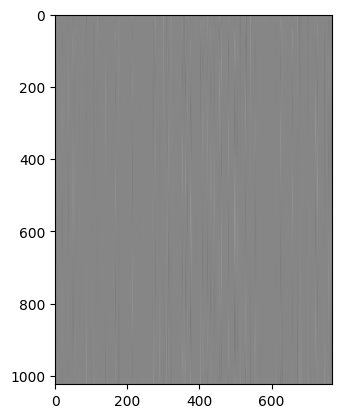

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(sd_hf['transformer.wpe.weight'], cmap='gray')

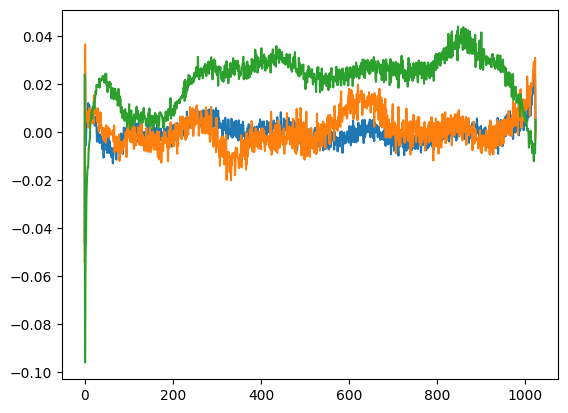

In [5]:
plt.plot(sd_hf['transformer.wpe.weight'][:, 150])
plt.plot(sd_hf['transformer.wpe.weight'][:, 200])
plt.plot(sd_hf['transformer.wpe.weight'][:, 250])

In [6]:
from transformers import pipeline, set_seed
generator = pipeline('text-generation', model='gpt2')
set_seed(42)
generator("Hello, I'm a language model,", max_length=30, num_return_sequences=5)

Device set to use cuda:0
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Hello, I\'m a language model, so you can\'t define something in any other language. Let me introduce another topic:\n\nThe name "'},
 {'generated_text': "Hello, I'm a language model, you know.\n\nThat's right… I have a lot of friends who don't know what I do"},
 {'generated_text': "Hello, I'm a language model, and I got this information from a Chinese dictionary from an English dictionary I had been reading for a long while,"},
 {'generated_text': "Hello, I'm a language model, not a computer programming language. I try as best I can to build your own, so you can follow me"},
 {'generated_text': "Hello, I'm a language model, the language model is the most fundamental framework for language operations. Today, I want to talk about a few other"}]

In [7]:
with open('input.txt', 'r') as f:
    text=f.read()
data = text[:1000]
print(data[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [8]:
import tiktoken
enc = tiktoken.get_encoding('gpt2')
tokens = enc.encode(data)
print(tokens[:24])

[5962, 22307, 25, 198, 8421, 356, 5120, 597, 2252, 11, 3285, 502, 2740, 13, 198, 198, 3237, 25, 198, 5248, 461, 11, 2740, 13]


In [9]:
import torch
buf = torch.tensor(tokens[:24 + 1])
x = buf[:-1].view(4,6)
y = buf[1:].view(4,6)
print(x)
print(y)

tensor([[ 5962, 22307,    25,   198,  8421,   356],
        [ 5120,   597,  2252,    11,  3285,   502],
        [ 2740,    13,   198,   198,  3237,    25],
        [  198,  5248,   461,    11,  2740,    13]])
tensor([[22307,    25,   198,  8421,   356,  5120],
        [  597,  2252,    11,  3285,   502,  2740],
        [   13,   198,   198,  3237,    25,   198],
        [ 5248,   461,    11,  2740,    13,   198]])


In [10]:
torch.compiler.list_backends()

['cudagraphs', 'inductor', 'onnxrt', 'openxla', 'tvm']

In [11]:
import torch
torch.cuda.is_available()

True

In [13]:
import os
os.cpu_count()

32

Min Train Loss: 3.110358
Min Validation Loss: 3.3293
Max Hellaswag eval: 0.2755


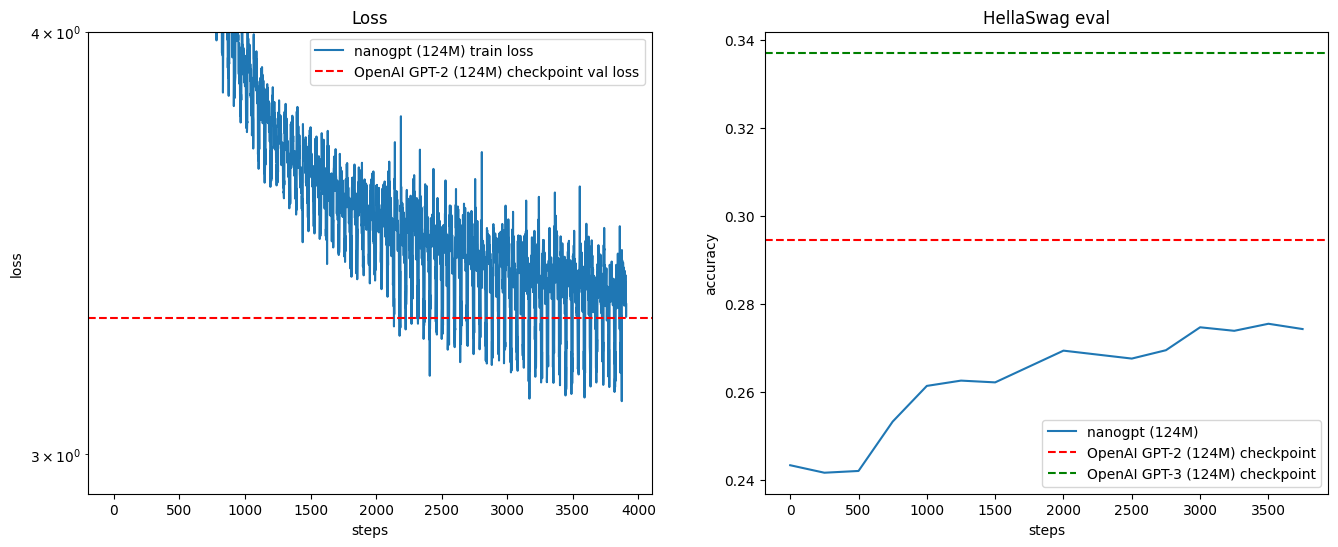

In [5]:
import numpy as np
import matplotlib.pyplot as plt
# % matplotlib inline

sz = '124M'

loss_baseline = {
    "124M": 3.2924,
}[sz]
hella2_baseline = { # Hellaswag for GPT-2
    "124M": 0.294463,
    "350M": 0.375224,
    "774M": 0.431986,
    "1558M": 0.488946,
}[sz]
hella3_baseline = { # Hellaswag for GPT-3
    "124M": 0.337,
    "350M": 0.436,
    "774M": 0.510,
    "1558M": 0.547,
}[sz]

# load the log file
with open('log/log.txt', 'r') as f:
    lines = f.readlines()
    
# parse the individual lines, group by stream (train, val, hella)
streams = {}
for line in lines:
    step, stream, val = line.strip().split()
    if stream not in streams:
        streams[stream] = {}
    streams[stream][int(step)] = float(val)
    
# convert each stream from {step: val} to (steps[], vals[])
streams_xy = {}
for k, v in streams.items():
    xy = sorted(list(v.items()))
    streams_xy[k] = list(zip(*xy))
    
plt.figure(figsize=(16, 6))

plt.subplot(121)
xs, ys = streams_xy['train'] # training loss
ys = np.array(ys)
plt.plot(xs, ys, label=f'nanogpt ({sz}) train loss')
print('Min Train Loss:', min(ys))
xy, ys = streams_xy['val'] # validation loss
# plt.plot(xs, ys, label=f'nanogpt ({sz}) val loss')
if loss_baseline is not None:
    plt.axhline(y=loss_baseline, color='r', linestyle='--', label=f"OpenAI GPT-2 ({sz}) checkpoint val loss")
plt.xlabel("steps")
plt.ylabel("loss")
plt.yscale('log')
plt.ylim(top=4.0)
plt.legend()
plt.title("Loss")
print("Min Validation Loss:", min(ys))

# Panel 2: HellaSwag eval
plt.subplot(122)
xs, ys = streams_xy["hella"] # HellaSwag eval
ys = np.array(ys)
plt.plot(xs, ys, label=f"nanogpt ({sz})")
# horizontal line at GPT-2 baseline
if hella2_baseline:
    plt.axhline(y=hella2_baseline, color='r', linestyle='--', label=f"OpenAI GPT-2 ({sz}) checkpoint")
if hella3_baseline:
    plt.axhline(y=hella3_baseline, color='g', linestyle='--', label=f"OpenAI GPT-3 ({sz}) checkpoint")
plt.xlabel("steps")
plt.ylabel("accuracy")
plt.legend()
plt.title("HellaSwag eval")
print("Max Hellaswag eval:", max(ys))